In [76]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import datetime as datetime
import json
from bs4 import BeautifulSoup
import requests
import pandas_montecarlo
%matplotlib inline


def fetchCryptoOHLC_byExchange(fsym, tsym, exchange):
    
    """
    a function fetches a crypto OHLC price-series for fsym/tsym and stores it in a pandas DataFrame; 
    uses specific Exchange as provided src: https://www.cryptocompare.com/api/
    """
 
    cols = ['date', 'timestamp', 'open', 'high', 'low', 'close']
    lst = ['time', 'open', 'high', 'low', 'close']
 
    timestamp_today = datetime.datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + \
              "&limit=2000" + "&e=" + exchange
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
 
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    # timestamp-to-date
                    td = datetime.datetime.fromtimestamp(int(y)).strftime('%Y-%m-%d')
                    tmp.append(td)  #(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):
                df.loc[len(df)] = np.array(tmp)
        df.index = pd.to_datetime(df.date)
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.iloc[0][0])
 
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
    
    return data.astype(np.float64)

In [77]:
def vixfix(btc,usd,exchange): 
    
    """
    Calculates vixfix for chosen asset and plots it
    """
    
    SPY = fetchCryptoOHLC_byExchange(btc,usd,exchange)
    SPY['Returns'] = SPY.close.pct_change()
    SPY = SPY[SPY['Returns']<0]
    wvf = (((SPY['close'].rolling(22).max() - SPY['low']) / SPY['close'].rolling(22).max())*100)

    pd = 20 #"LookBack Period Standard Deviation High")
    bbl = 20 #"Bolinger Band Length")
    mult = 2.0 #"Bollinger Band Standard Devaition Up"
    lb = 50  #"Look Back Period Percentile High")
    ph = .90 #"Highest Percentile - 0.90=90%, 0.95=95%, 0.99=99%")
    pl = 1.1 #"Lowest Percentile - 1.10=90%, 1.05=95%, 1.01=99%")

    sDev = mult * wvf.rolling(20).std()
    midLine = wvf.rolling(10).mean()
    lowerBand = midLine - sDev
    upperBand_20 = midLine + sDev

    rangeHigh_10 = wvf.rolling(10).max()
    rangeHigh_20 = wvf.rolling(20).max()
    rangeHigh_50 = wvf.rolling(50).max()
    rangeLow = wvf.rolling(50).min() * pl

    Greater = []
    Colors = []
    Threshold = []

    for i in range(len(wvf)):
        if wvf[i] >= upperBand_20[i]:
            Greater.append(i)
            Colors.append('lime')
        if ((wvf[i] >= rangeHigh_20[i]) | (wvf[i] >= rangeHigh_50[i]) | (wvf[i] >= rangeHigh_10[i])):
            Greater.append(i)
            Colors.append('lime')
        if wvf[i] > 35:
            Threshold.append(i)
        else:
            Colors.append('black')

    plt.style.use('seaborn-white')
    plt.rcParams['axes.linewidth'] = 0.1
    plt.figure(figsize=(7,6))
    plt.suptitle(btc+' '+usd+' Volatility', fontsize=12, y=0.96)

    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1, sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False);

    ax1.grid(False)
    ax2.grid(False)

    ax1.plot(SPY['close'], c='black',label='')
    ax1.plot(SPY['close'],lw=0,markevery=Greater,marker='o',markersize='6',markerfacecolor='lime',alpha=0.4,label='Signal')
    ax1.tick_params(axis='both', which='major', labelsize=8)
    
    for i in Threshold:
        ax1.axvline(SPY.index[i],color='lime',alpha=0.2)

    ax2.plot(upperBand_20, color='red', alpha=1,lw=0.5)
    ax2.plot(rangeHigh_10, color='green', alpha=1,lw=0.5)
    ax2.plot(rangeHigh_20, color='blue', alpha=1,lw=0.5)
    ax2.plot(rangeHigh_50, color='black', alpha=1,lw=0.5)

    ax2.plot(wvf,lw=0.5,color='black',alpha=1,label='Volatility indicator')
    ax2.plot(wvf,lw=0,alpha=0.4,label='',markevery=Greater,marker='o',markersize='6',markerfacecolor='lime')
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.fill_between(wvf.index,wvf,color='black',alpha=0.1)

    ax2.axhline(35,ls='--',color='black',lw=0.5)

    ax1.legend(fontsize='medium', loc=2)
    ax2.legend(fontsize='medium', loc=2)
    
    limit = (datetime.datetime.now() + datetime.timedelta(15)).strftime("%Y-%m-%d")
    ax1.set_xlim(['2017-06-01',limit])
    ax2.set_xlim(['2017-06-01',limit])

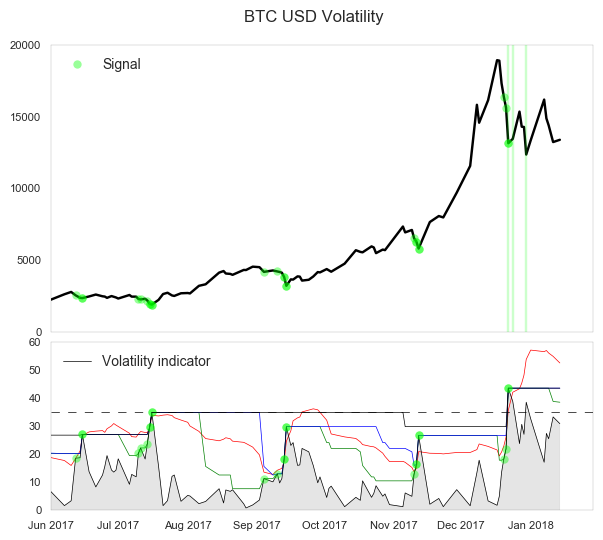

In [78]:
vixfix('BTC','USD','Bitfinex')